#### Initial baseline models tested were Logistic regression, LinearSVC, and Randomforest. Logisticeregression did perform well interms of F1 score and accuracy after class_weights = balanced arguments. Similarly LinearSVC also did perform well while Random forest didnot do well even after hyperparameter tuning. MultinomialNB also perform decent. Since my idea of getting features name with probabilities can be done in MultinomialNB and while getting feature importance from Logisticregression and linearSVC was not available, I used mutinomialNB in this project. 

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from imblearn.over_sampling import SMOTE
#from imblearn.combine import SMOTEENN
from sklearn.utils import class_weight

%matplotlib inline

In [2]:
# import csv file the was saved from EDA
drugs_model = pd.read_csv('drugs_model.csv').astype('U')

In [3]:
drugs_model.head()

UniqueID                  drugName                     condition  \
0   206461                 Valsartan  Left Ventricular Dysfunction   
1    95260                Guanfacine                          ADHD   
2    92703                    Lybrel                 Birth Control   
3   138000                Ortho Evra                 Birth Control   
4    35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review rating        date  \
0  "It has no side effect, I take it in combinati...    9.0  2012-05-20   
1  "My son is halfway through his fourth week of ...    8.0  2010-04-27   
2  "I used to take another oral contraceptive, wh...    5.0  2009-12-14   
3  "This is my first time using any form of birth...    8.0  2015-11-03   
4  "Suboxone has completely turned my life around...    9.0  2016-11-27   

  usefulCount character_length word_count  \
0          27               79         17   
1         192              741        141   
2          17              755        133   
3          10              448         89   
4          37              719        134   

                                          clean_text rating_class  \
0  it has no side effect i take it in combination...     positive   
1  my son is halfway through his fourth week of i...     positive   
2  i used to take another oral contraceptive whic...      neutral   
3  this is my first time using any form of birth ...     positive   
4  suboxone has completely turned my life around ...     positive   

  rating_class_numeric  
0                    2  
1                    2  
2                    1  
3                    2  
4                    2

In [4]:
# Assign the features and labels. Covert to array and reshape clean_text
X =drugs_model['clean_text'].values.reshape(-1,1)
y=drugs_model['rating_class']



In [5]:
# stop = set(stopwords.words("english"))
# stop.update(("mg","day", 'hv','month', 'first','time', 'took','week', 'year', 'phentermine', 'adipex', 'belviq', 'contrave'))

In [6]:
# Bag words with TFIDF vectorizer. After test several ngram ranges(1,2), (2,3), (3,4) , (4,4) I am using (4, 4) 
#to get meaningful insights into the phrase the model is using 
tfidf= TfidfVectorizer(ngram_range = (4,4), min_df = 10,sublinear_tf=True)
X =tfidf.fit_transform(X.ravel())

In [7]:
#print the shape of the features and target label
print(X.shape)
print(y.shape)

(215063, 95230)
(215063,)


In [8]:
# split the features and labels into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 42)

In [9]:
# Tested SMOTE to upsample the imbalanced classes and it does seem to improve the accuracy of the model. Since my goal was to 
# identify the key terms or phrases in this project, I didnot use smote. Uncomment if used. It took long time > 20 mts for SMOTE to run

# method = SMOTE()

# # Create the resampled feature set
# X_resampled, y_resampled = method.fit_sample(X_train, y_train)

In [10]:
# # uncomment to check if the SMOTE worked. 
## Print the value_counts on the original labels y
#print(pd.value_counts(pd.Series(y)))

# print(drugs_model.rating_class.value_counts())

# Print the value_counts
#print(pd.value_counts(pd.Series(y_resampled)))

In [11]:
# printing classes
classes = np.unique(y)
print(classes)

['negative' 'neutral' 'positive']


In [12]:
# checking the shape of train test split
print(X.shape)
print(y.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(215063, 95230)
(215063,)
(150544, 95230)
(64519, 95230)
(150544,)
(64519,)


In [13]:
# use multinomialNB as the baseline model for text classification. It seems to be fast, sensitive and accurte. 

In [14]:
mnb = MultinomialNB(fit_prior=True)
mnb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [15]:
# Checking which alpha values give better accuracy score in the model 

alphas = np.arange(0.001,1, step=0.1)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    mnb = MultinomialNB(alpha=alpha)
    # Fit to the training data
    mnb.fit(X_train, y_train)
    # Predict the labels: pred
    pred = mnb.predict(X_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.001
Score:  0.8156202049008819

Alpha:  0.101
Score:  0.810675924921341

Alpha:  0.201
Score:  0.8049566794277655

Alpha:  0.30100000000000005
Score:  0.8007408670314171

Alpha:  0.401
Score:  0.7965095553247881

Alpha:  0.501
Score:  0.7931617043041584

Alpha:  0.6010000000000001
Score:  0.7897983539732482

Alpha:  0.7010000000000001
Score:  0.7870239774330042

Alpha:  0.801
Score:  0.7851175622684791

Alpha:  0.901
Score:  0.7832111471039539



In [16]:
print(X.shape)
print(y.shape)

(215063, 95230)
(215063,)


In [17]:
# since alpha value of 0.001 gave highest accuracy, we will use that in the arguments and rerun the model 

mnb = MultinomialNB(alpha = 0.001,fit_prior=True)
mnb.fit(X_train,y_train)
mnb_predictions = mnb.predict(X_test)

In [18]:
# print the metrics for the model 

print(confusion_matrix(y_test,mnb_predictions))
print('\n', 'Classification report')
print(classification_report(y_test,mnb_predictions))
# Print the overall accuracy
print('\n', 'accuracy Score')
print(metrics.accuracy_score(y_test,mnb_predictions))

print('\n', 'f1 Score')
print(metrics.f1_score(y_test, mnb_predictions, average='weighted'))

[[10089   182  5819]
 [  912  1723  3229]
 [ 1596   158 40811]]

 Classification report
              precision    recall  f1-score   support

    negative       0.80      0.63      0.70     16090
     neutral       0.84      0.29      0.43      5864
    positive       0.82      0.96      0.88     42565

   micro avg       0.82      0.82      0.82     64519
   macro avg       0.82      0.63      0.67     64519
weighted avg       0.82      0.82      0.80     64519


 accuracy Score
0.8156202049008819

 f1 Score
0.7975461768384874


In [19]:
# as 0.79 seems to be a decent f1 score. lets get probablities and extract but the model didnot perfor well in recall which is actual predicted words
#feature importance the model is in the predictions of ratings

probabilities_mnb = mnb.predict_proba(X_test)
class_labels = mnb.classes_
class_labels = class_labels.tolist()
y = label_binarize(y, classes=class_labels)
n_classes = y.shape[1]
y_dummies=pd.get_dummies(y_test)

In [20]:
print(class_labels)
print(n_classes)

['negative', 'neutral', 'positive']
3


In [21]:
# print probablities from multinomialNB model 
probabilities_mnb

array([[2.50413378e-05, 4.05411639e-04, 9.99569547e-01],
       [9.67528998e-01, 1.49453540e-02, 1.75256484e-02],
       [2.12318440e-01, 8.16882819e-05, 7.87599872e-01],
       ...,
       [8.52088144e-01, 1.30867124e-04, 1.47780988e-01],
       [3.22337643e-03, 1.31513622e-02, 9.83625261e-01],
       [3.83927950e-02, 2.41636375e-03, 9.59190841e-01]])

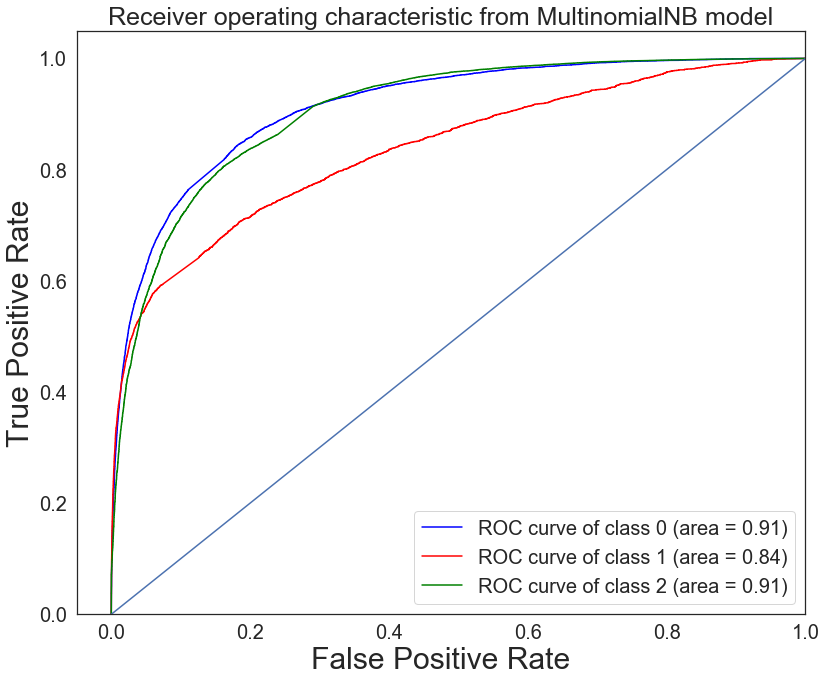

In [22]:
# plot Recieving operating Curve(ROC) and calcuate Area under the curve(AUC)
sns.set(rc={'figure.figsize':(12,10)}, font_scale=2)
sns.set_style("white")
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_dummies.iloc[:, i], probabilities_mnb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1])
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 30)
plt.ylabel('True Positive Rate',fontsize = 30)
plt.title('Receiver operating characteristic from MultinomialNB model',fontsize = 25)
plt.tight_layout()
plt.legend(loc="lower right", fontsize = 20)
plt.savefig('roccurve all data.png');

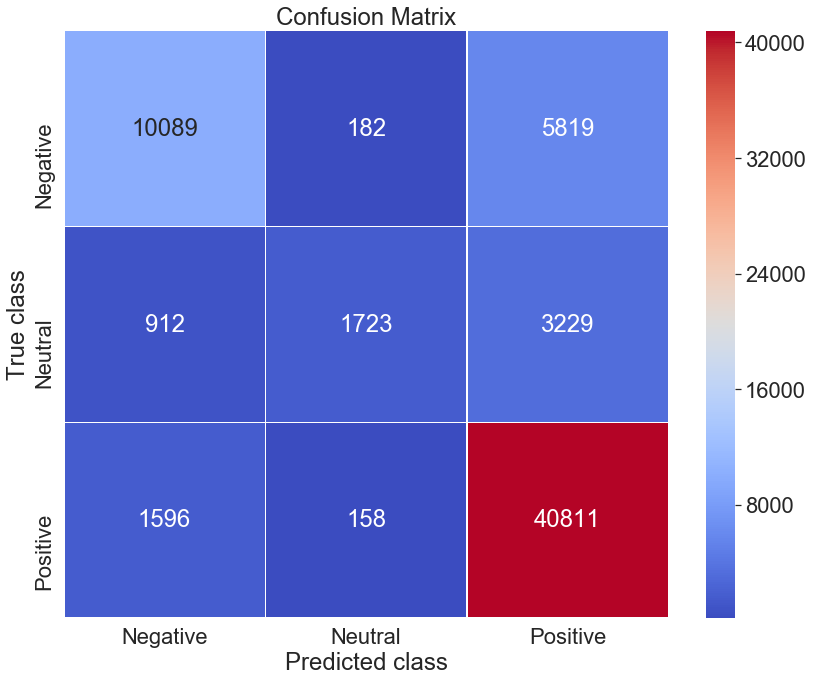

In [23]:
# plot confusion matrix

sns.set(rc={'figure.figsize':(12,10)}, font_scale=2)
ax= plt.subplot()
cm = confusion_matrix(y_test, mnb_predictions)
sns.heatmap(cm, annot=True, ax = ax, fmt='g', linewidths=.5, cmap='coolwarm'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted class')
ax.set_ylabel('True class')
ax.set_title('Confusion Matrix')
plt.tight_layout()
ax.xaxis.set_ticklabels(['Negative',  'Neutral', 'Positive']); 
ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])
plt.savefig('confusion Matrix all data.png');

In [24]:
class_labels = mnb.classes_
class_labels = class_labels.tolist()
class_labels

['negative', 'neutral', 'positive']

In [25]:
# topn_class1= class_labels[2]
# topn_class2= class_labels[1]
# topn_class3= class_labels[0]

In [26]:
# found a nice code from stackover and modified it to get the feature name and codes and convert into data frame. 

def important_features(vectorizer,clf,n):
    class_labels = clf.classes_
    feature_names =vectorizer.get_feature_names()
    topn_class1 = pd.DataFrame(sorted(zip(clf.feature_count_[2], feature_names),reverse=True)[:n],columns = ['Freq', 'Feature Name'])
    topn_class2 = pd.DataFrame(sorted(zip(clf.feature_count_[1], feature_names),reverse=True)[:n],columns = ['Freq', 'Feature Name'])
    topn_class3 = pd.DataFrame(sorted(zip(clf.feature_count_[0], feature_names),reverse=True)[:n],columns = ['Freq', 'Feature Name'])        
    return topn_class1, topn_class2, topn_class3


In [27]:
# Generte three data frames from top 50 features with feature counts
topn_class1, topn_class2, topn_class3 =important_features(tfidf,mnb,50)

In [28]:
# Assign each data frame into rating type with Feature name and frequency of each feature
positive_rating = topn_class1[['Feature Name', 'Freq']]
neutral_rating=topn_class2[['Feature Name', 'Freq']]
negative_rating=topn_class3[['Feature Name', 'Freq']]


In [29]:
print(positive_rating)

               Feature Name        Freq
0        for the first time  230.656164
1            been on it for  225.362837
2       had no side effects  216.728669
3      the only side effect  215.822108
4            so far so good  208.086020
5       the only thing that  174.714170
6        in the morning and  155.324103
7          this is the only  153.611888
8      with no side effects  153.513602
9       has changed my life  153.217166
10      side effects at all  150.368096
11        the first time in  149.729825
12        have been on this  148.218721
13          have been on it  134.794894
14            ve been on it  132.829049
15      no side effects and  125.415434
16         doctor put me on  121.146721
17         have not had any  118.938710
18          ve been on this  118.691817
19       no side effects at  118.480393
20         this is the best  114.445119
21          me my life back  111.939298
22     the side effects are  111.486581
23      of the side effects  110.488316


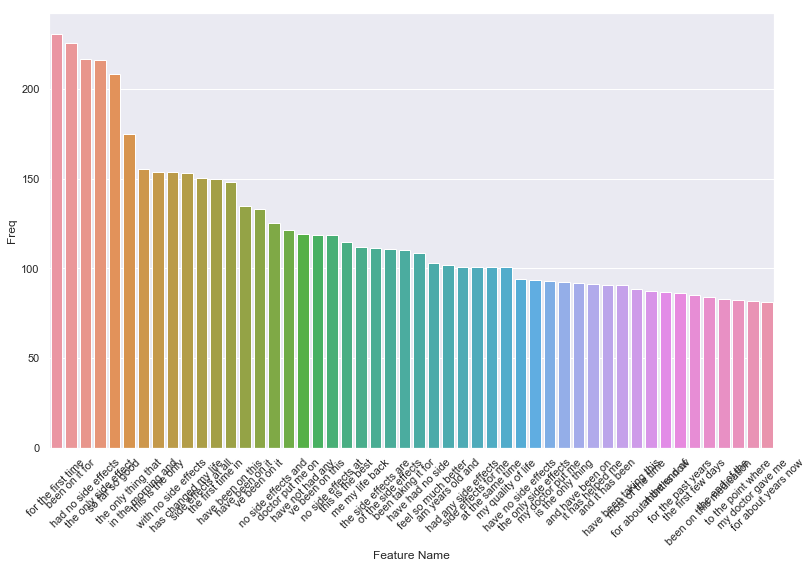

In [30]:
# plot barplot for the features and frequencies
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Feature Name", y="Freq", data=positive_rating)
h.set_xticklabels(h.get_xticklabels(), rotation=45);

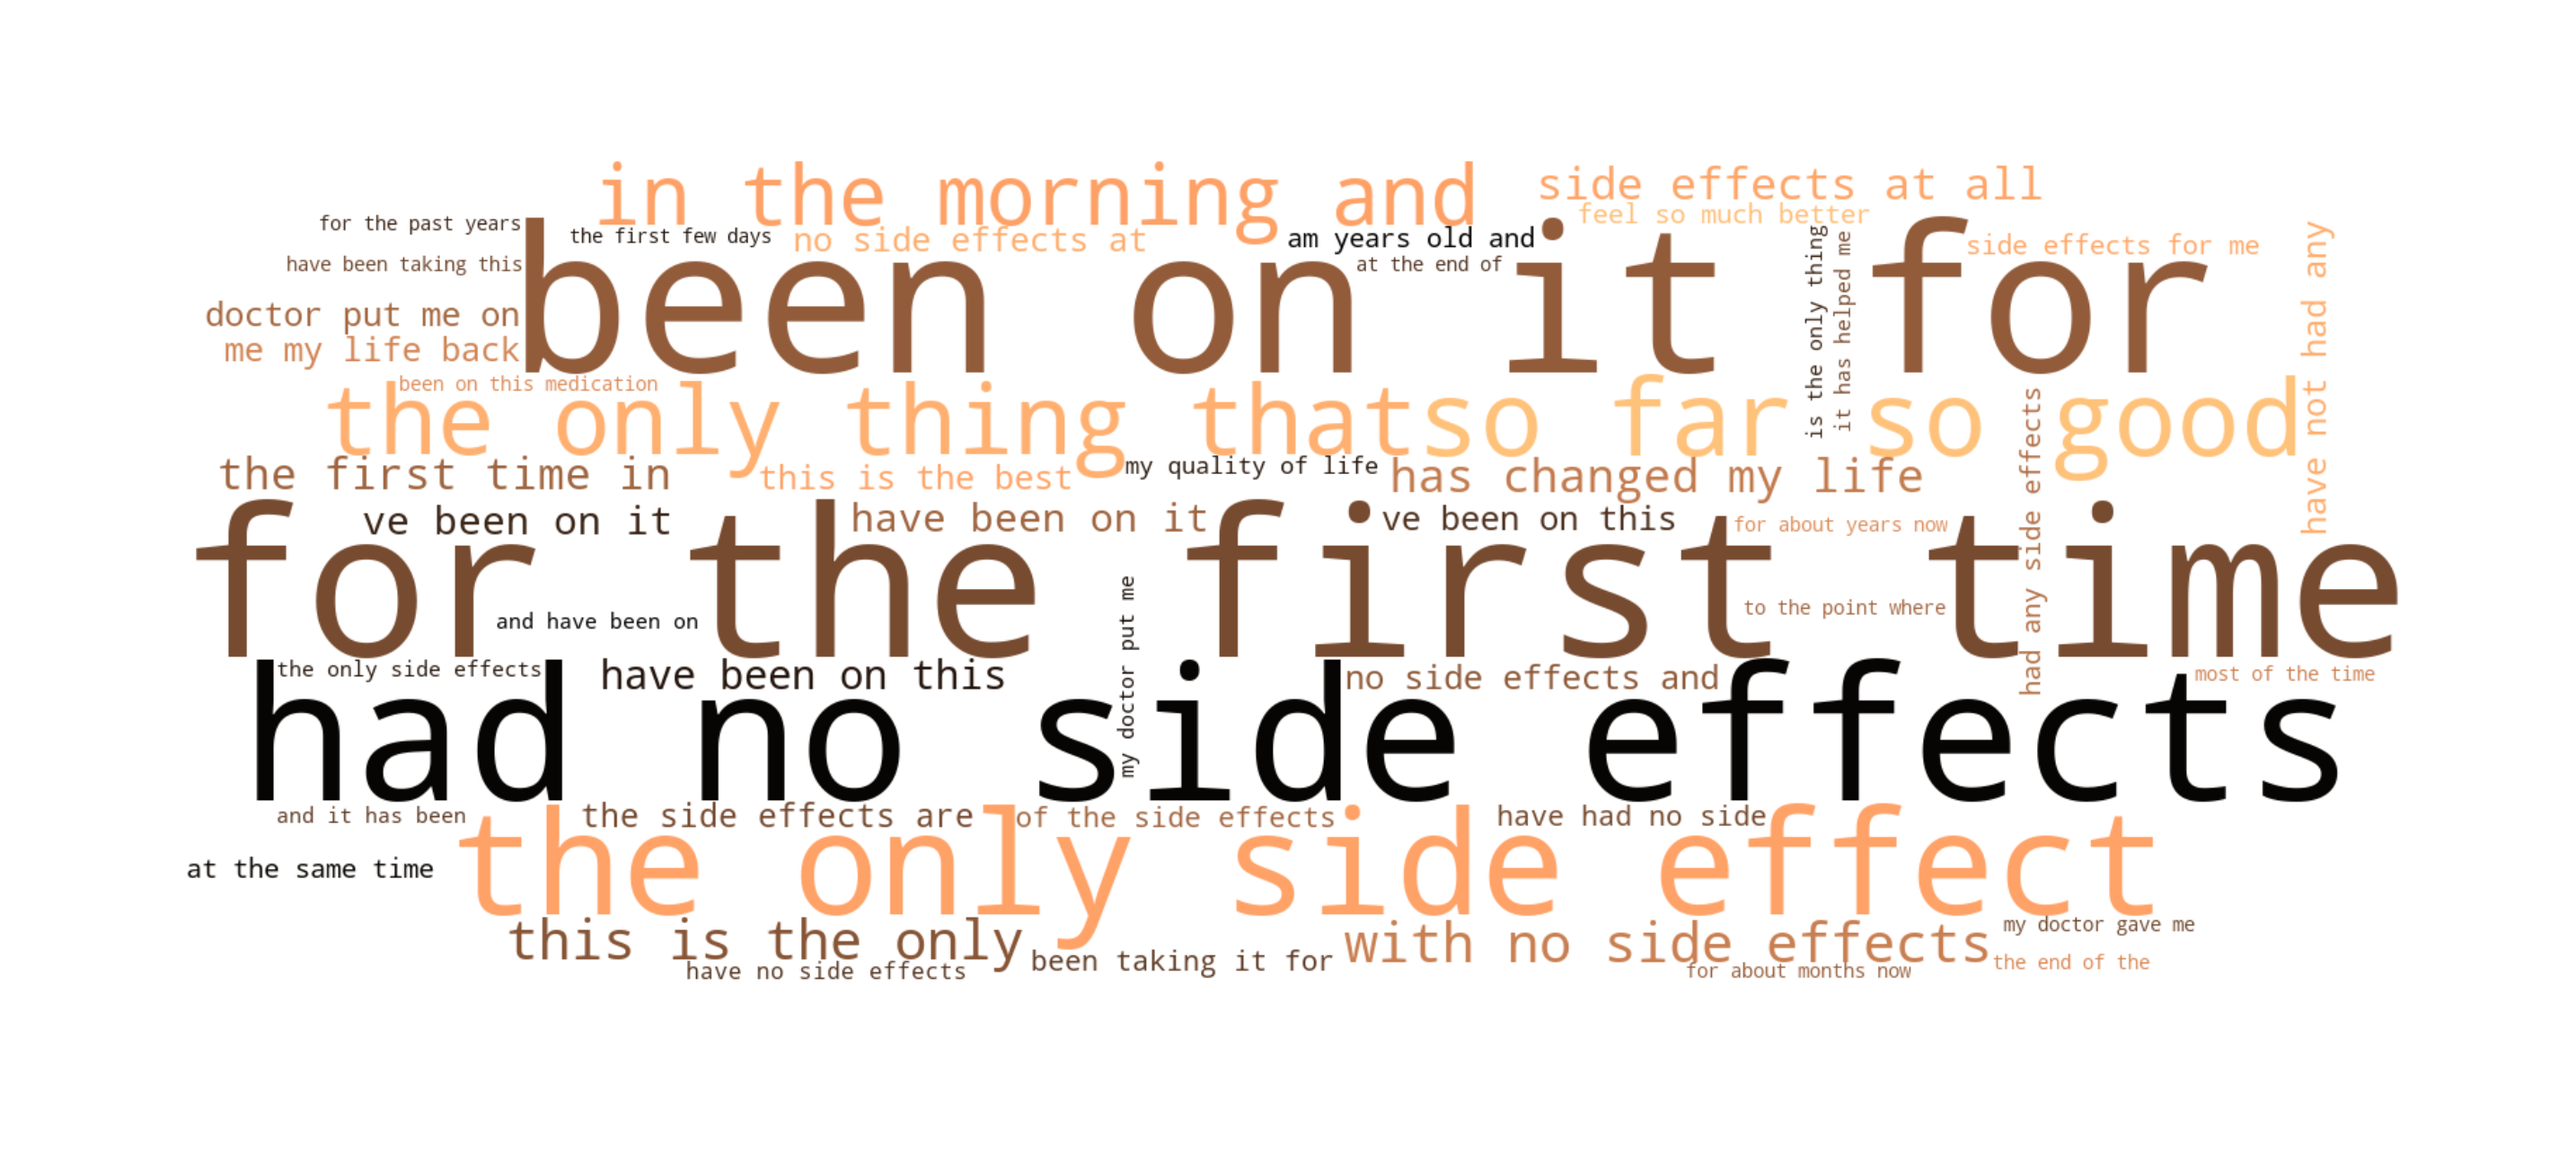

In [31]:
# Create word cloud from the data frame of features and feature counts from positive rating
capsule = np.array(Image.open("Download-Capsule-PNG-Images.png"))
positive = {}
for w, x in positive_rating.values:
    positive[w] = x
wordcloud = WordCloud(width = 4000,
    height = 3000,background_color='white', mask = capsule,colormap=plt.cm.copper,collocations=False, random_state = 30)
wordcloud.generate_from_frequencies(positive)
plt.figure(figsize = (40, 30),
    
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.savefig('positive word cloud all data')
plt.show()


In [32]:
print(neutral_rating)

               Feature Name       Freq
0      the side effects are  37.616934
1      but the side effects  33.021808
2            been on it for  31.001784
3         have been on this  26.469859
4       of the side effects  23.366386
5           ve been on this  23.259314
6     the side effects were  20.808790
7          at the same time  20.567533
8         to stop taking it  19.873571
9             ve been on it  17.741201
10           not sure if it  17.354518
11          have been on it  17.322479
12       tired all the time  17.143015
13       in the morning and  16.608783
14    on this birth control  16.512113
15       for the first time  16.304277
16       to the point where  16.303779
17           so far so good  16.226888
18       had to stop taking  15.809119
19         all the time and  15.756592
20         most of the time  15.437008
21         on this pill for  15.295038
22        taste in my mouth  15.287235
23         in the middle of  15.064241
24         been on this f

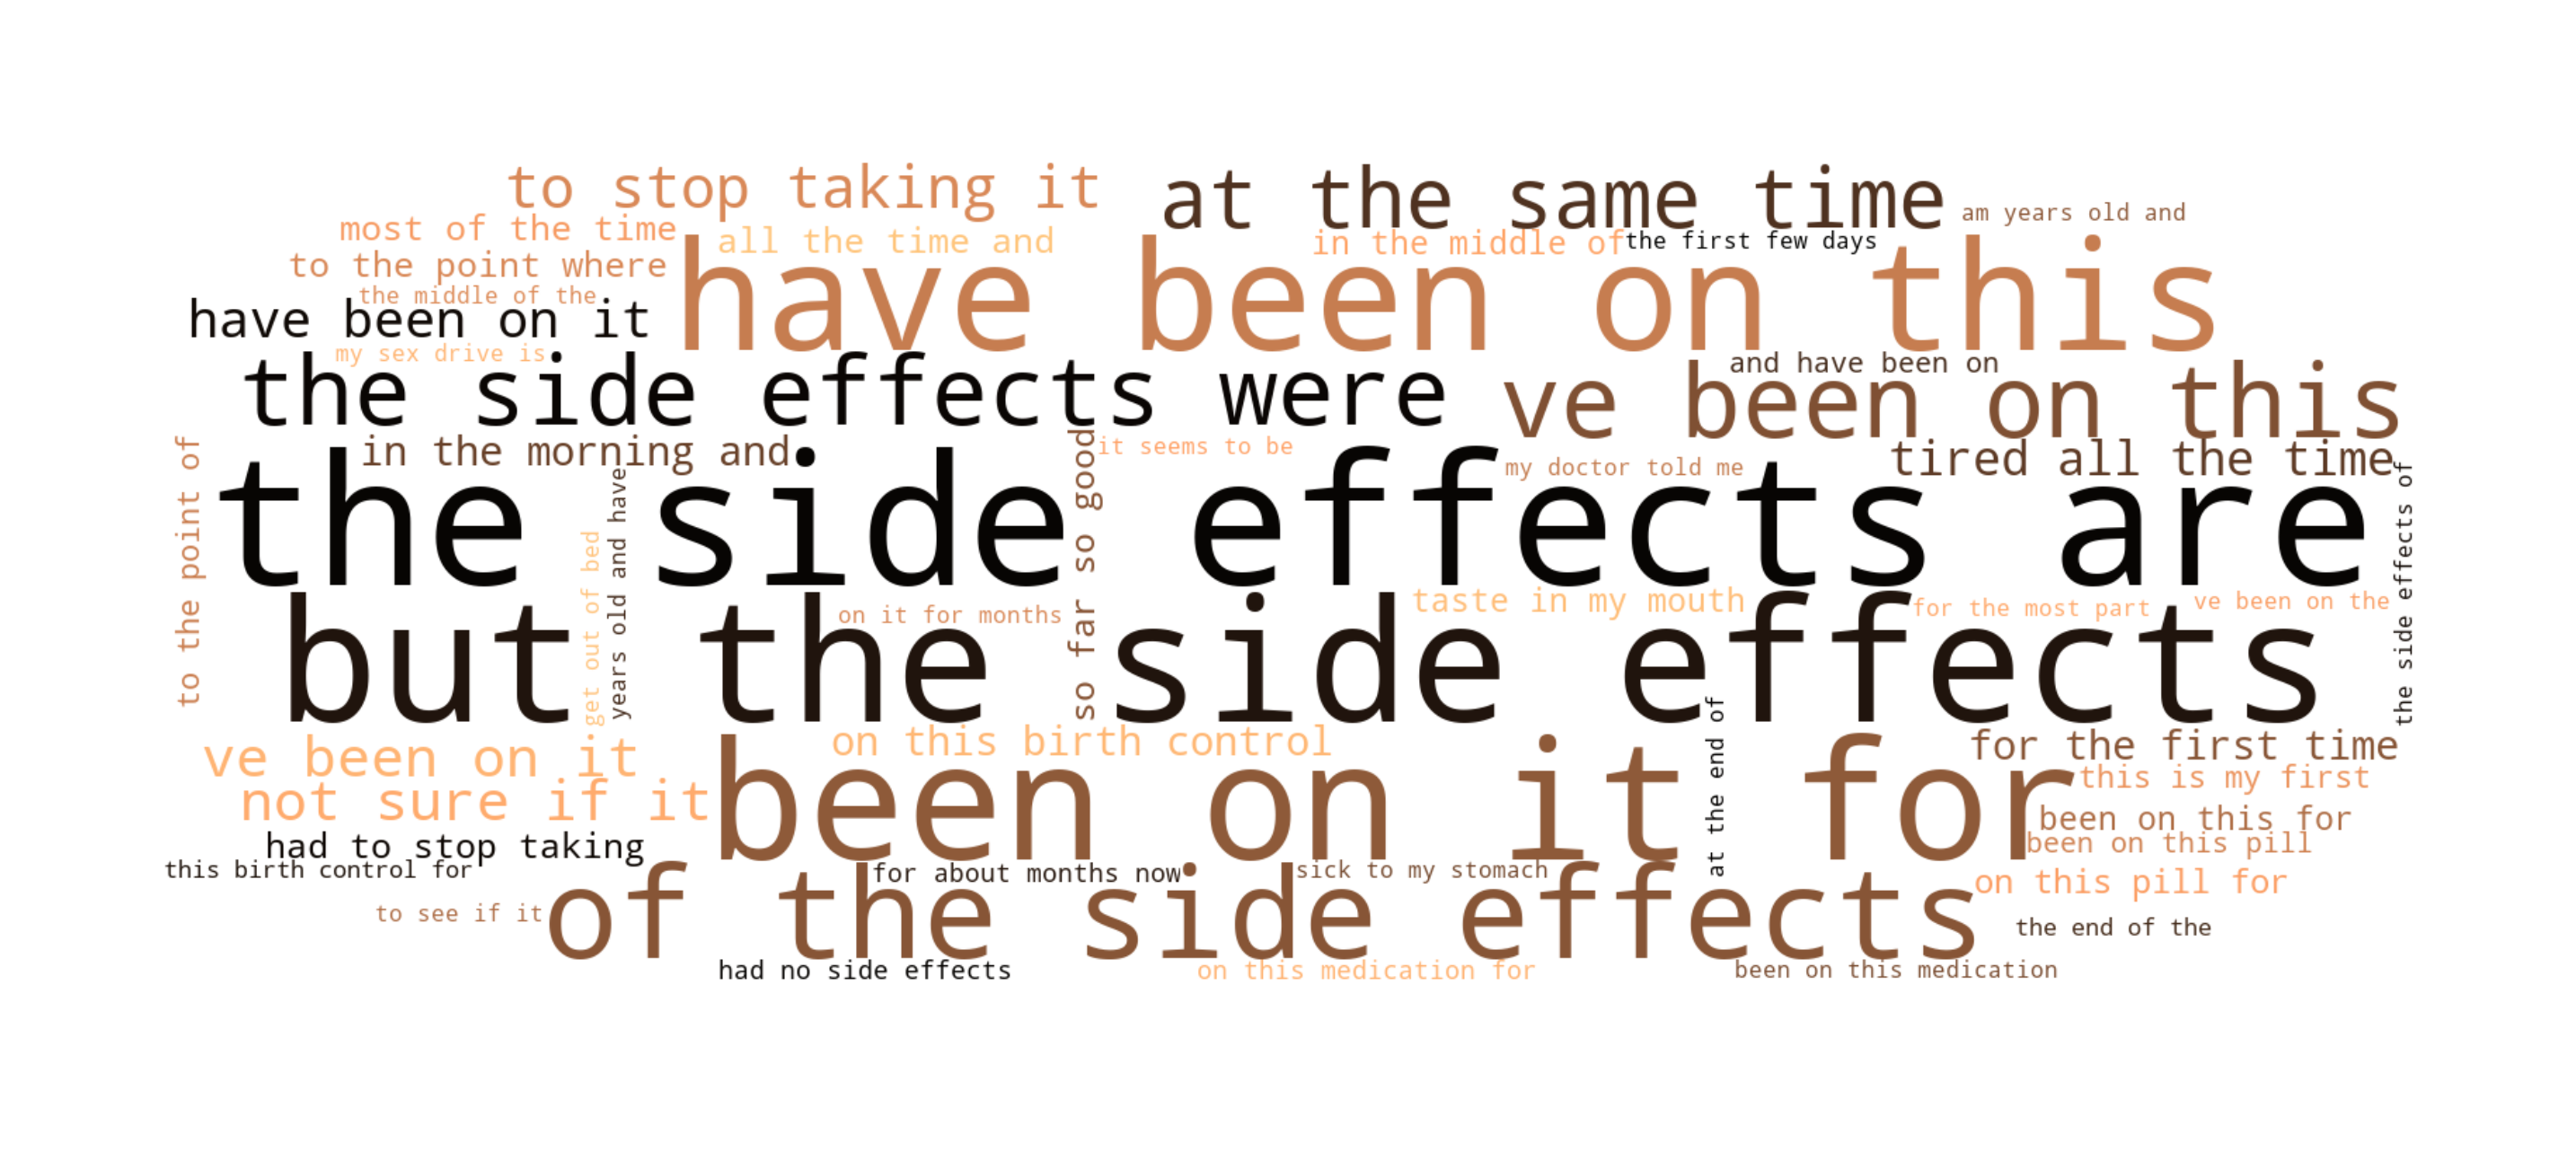

In [33]:
# Create word cloud from the data frame of features and feature counts from neutral rating
neutral = {}
for w, x in neutral_rating.values:
    neutral[w] = x
wordcloud = WordCloud(width = 3000,
    height = 2000,background_color='white',mask = capsule,colormap=plt.cm.copper, collocations=False, random_state = 20)
wordcloud.generate_from_frequencies(neutral)
plt.figure(figsize = (40, 30),
    
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.savefig('neutral word cloud all data')
plt.show()

In [34]:
print(negative_rating)

                Feature Name       Freq
0   would not recommend this  72.388969
1      do not recommend this  69.255110
2           do not take this  68.600870
3       the side effects are  63.516652
4      the side effects were  63.002451
5            not work for me  62.907263
6       but the side effects  58.954246
7          to stop taking it  56.530909
8           didn work for me  56.497806
9           did not work for  55.948973
10            been on it for  54.763776
11          in the middle of  53.437749
12          all the time and  52.725493
13          on this pill for  51.652446
14         have been on this  51.386064
15       of the side effects  48.431381
16        had to stop taking  47.955791
17        to the point where  47.838192
18           ve been on this  46.600936
19              to go to the  45.972268
20            get out of bed  45.533632
21         this is the worst  44.618181
22       stay away from this  42.576969
23         the middle of the  42.190949


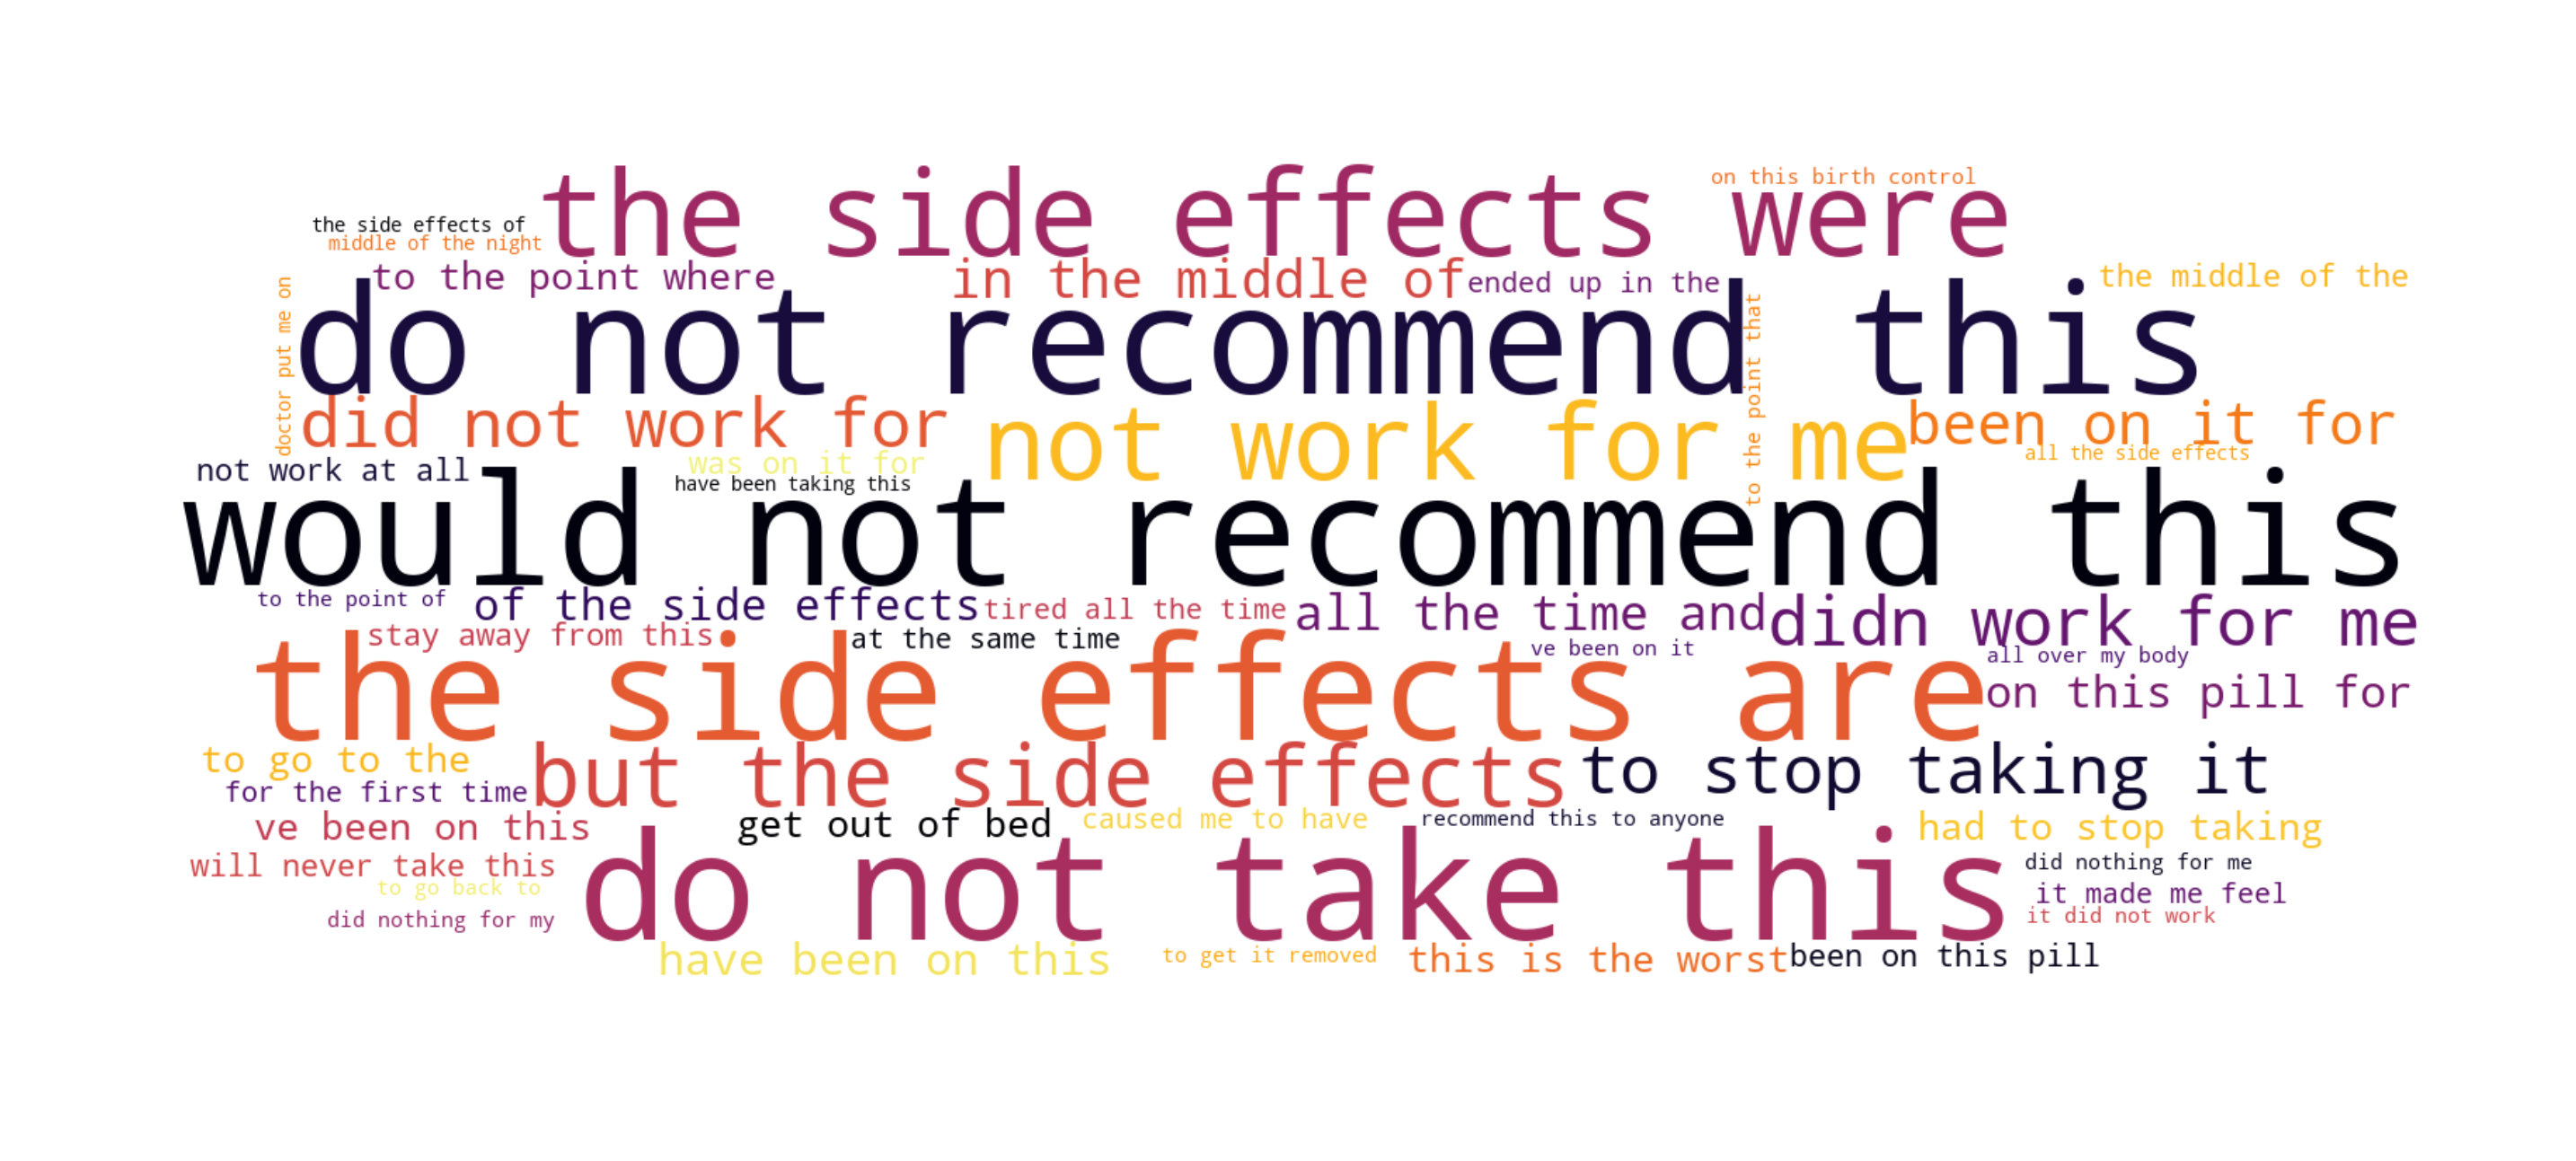

In [35]:
# Create word cloud from the data frame of features and feature counts from negative rating
negative = {}
for w, x in negative_rating.values:
    negative[w] = x
wordcloud = WordCloud(width = 3000,
    height = 2000,background_color='white',mask = capsule, colormap=plt.cm.inferno, collocations=False, random_state = 20)
wordcloud.generate_from_frequencies(negative)
plt.figure(figsize = (40, 30),
    
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.savefig('negative word cloud all data')
plt.show()